### Initiation

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# read the words
words = open('names.txt', 'r').read().splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [8]:
# build the vocabulary
chars = sorted(list(set(''.join(words))))
s_to_i = {'.' : 0} | {s: i + 1 for i, s in enumerate(chars)}
i_to_s = {i: s for s, i in s_to_i.items()}
vocab_size = len(i_to_s)
print(i_to_s)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [9]:
# build the dataset

block_size = 3 # context length (how many chars to predict next)

def build_dataset(words):
	X, Y = [], []

	for w in words:
		context = [0] * block_size
		for ch in w + '.':
			idx = s_to_i[ch]
			X.append(context)
			Y.append(idx)
			context = context[1:] + [idx]
	
	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

X_train,	Y_train	= build_dataset(words[:n1])		# 80%
X_val,		Y_val	= build_dataset(words[n1:n2])	# 10%
X_test,		Y_test	= build_dataset(words[n2:])		# 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Scratch

In [58]:
n_embd = 10 # embedding size
n_hidden = 200 # hidden layer size

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),				generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),	generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn((n_hidden,),						generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),			generator=g) * 0.01
b2 = torch.randn((vocab_size,),						generator=g) * 0

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

12297


In [59]:
max_steps = 200000
lossi = []
batch_size = 32

for i in range(max_steps):
	
	# minibatch
	minibatch = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
	Xb, Yb = X_train[minibatch], Y_train[minibatch]

	# forward pass
	emb = C[Xb] # embed chars to vectors
	emb_cat = emb.view(emb.shape[0], -1) # concatenate embeddings
	# linear layer
	h_preact = emb_cat @ W1 # + b1 # hidden layer preactivation
	# batch norm layer
	# --------------------------------
	bn_mean_i = h_preact.mean(0, keepdim=True)
	bn_std_i = h_preact.std(0, keepdim=True)
	h_preact = bn_gain * (h_preact - bn_mean_i) / bn_std_i + bn_bias # batch normalization
	
	with torch.no_grad():
		bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
		bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
	# --------------------------------
	# non-linearity
	h = torch.tanh(h_preact) # hidden layer activation
	logits = h @ W2 + b2 # output layer
	loss = F.cross_entropy(logits, Yb) # loss function

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	if i < 100000:
		lr = 0.1
	else:
		lr = 0.01
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	if i % 10000 == 0:
		print(f'{i:7d}/ {max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())

      0/  200000: 3.3147
  10000/  200000: 2.1984
  20000/  200000: 2.3375
  30000/  200000: 2.4359
  40000/  200000: 2.0119
  50000/  200000: 2.2595
  60000/  200000: 2.4775
  70000/  200000: 2.1020
  80000/  200000: 2.2788
  90000/  200000: 2.1862
 100000/  200000: 1.9474
 110000/  200000: 2.3010
 120000/  200000: 1.9837
 130000/  200000: 2.4523
 140000/  200000: 2.3839
 150000/  200000: 2.1987
 160000/  200000: 1.9733
 170000/  200000: 1.8668
 180000/  200000: 1.9973
 190000/  200000: 1.8347


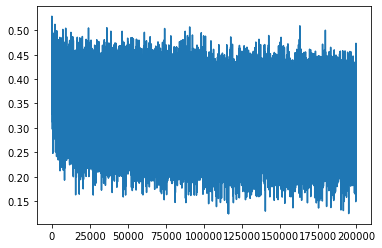

In [60]:
plt.plot(lossi)

In [52]:
# calibrate the batch norm at the end of training

with torch.no_grad():
	# pass the training set through the network
	emb = C[X_train]
	emb_cat = emb.view(emb.shape[0], -1)
	h_preact = emb_cat @ W1 + b1
	bn_mean = h_preact.mean(0, keepdim=True)
	bn_std = h_preact.std(0, keepdim=True)

In [61]:
@torch.no_grad() # disable autograd
def split_loss(split):
	x, y = {
		'train': (X_train, Y_train),
		'val': (X_val, Y_val),
		'test': (X_test, Y_test)
	}[split]
	emb = C[x] # (N, block_size, n_embd)
	emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
	h_preact = emb_cat @ W1 + b1 # (N, n_hidden)
	h_preact = bn_gain * (h_preact - bn_mean_running) / bn_std_running + bn_bias
	h = torch.tanh(h_preact) # (N, n_hidden)
	logits = h @ W2 + b2 # (N, vocab_size)
	loss = F.cross_entropy(logits, y)
	print(f'{split:5s} | loss: {loss.item():.6f}')

split_loss('train')
split_loss('val')

train | loss: 2.066592
val   | loss: 2.105057


In [63]:
for _ in range(20):
	out = []
	context = [0] * block_size # init with: '...'
	while True:
		# forward pass the neural net
		emb = C[torch.tensor(context)] # (1, block_size, n_embd)
		h = torch.tanh(emb.view(1, -1) @ W1 + b1)
		logits = h @ W2 + b2
		probs = F.softmax(logits, dim=1)
		# sample from the distribution
		ix = torch.multinomial(probs, num_samples=1).item()
		# shift the context window
		context = context[1:] + [ix]
		out.append(ix)
		# if we generated the end token, break
		if ix == 0:
			break
	
	print(''.join(i_to_s[i] for i in out[:-1])) # decode and print

lugstiberissirets
bmaimlos
shdyn
qwmetss
prlsteph
ssurshitnteldmbertbu
fnixandri
qlissaniyah
basthedps
baclynnssammariessprnsergnnkecio
dveyths
sasdsm
jamadie
matth
fallyssafrudhristivraysissangustdta
stel
dequisabraysh
vadya
shafnyamarbhudss
saxshutimarliverstobeja


### To PyTorch specifics

In [30]:
class Linear:
	def __init__(self, fan_in, fan_out, bias=True):
		self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
		self.bias = torch.zeros(fan_out) if bias else None
	
	def __call__(self, x):
		self.out = x @ self.weight
		if self.bias is not None:
			self.out += self.bias
		return self.out
	
	def parameters(self):
		return [self.weight] + ([self.bias] if self.bias is not None else [])
		

In [31]:
class BatchNorm1d:
	def __init__(self, dim, eps=1e-5, momentum=0.1):
		self.eps = eps
		self.momentum = momentum
		self.training = True
		# parameters trained with backprop
		self.gamma = torch.ones(dim)
		self.beta = torch.zeros(dim)
		# running statistics
		self.running_mean = torch.zeros(dim)
		self.running_var = torch.ones(dim)
	
	def __call__(self, x):
		# calculate the forward pass
		if self.training:
			mean = x.mean(0, keepdim=True) # batch mean
			var = x.var(0, keepdim=True) # batch variance
		else:
			mean = self.running_mean
			var = self.running_var
		x_hat = (x - mean) / torch.sqrt(var + self.eps)
		self.out = self.gamma * x_hat + self.beta
		# update running statistics
		if self.training:
			with torch.no_grad():
				self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
				self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
		return self.out
	
	def parameters(self):
		return [self.gamma, self.beta]
		

In [32]:
class Tanh:
	def __call__(self, x):
		self.out = torch.tanh(x)
		return self.out
	def parameters(self):
		return []

In [95]:
n_embd = 10 # embedding size
n_hidden = 100 # hidden layer size
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
	Linear(n_embd * block_size, n_hidden), 	BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden), 			BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden), 			BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden), 			BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden), 			BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size),			BatchNorm1d(vocab_size),
]

with torch.no_grad():
	# last layer: make less confident
	layers[-1].gamma *= 0.1
	# layers[-1].weight *= 0.1
	# all others: apply gain
	for l in layers[:-1]:
		if isinstance(l, Linear):
			l.weight *= 5/3

parameters = [C] + [p for l in layers for p in l.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

47551


In [96]:
max_steps = 200000
batch_size = 32
lossi = []
update_to_data = []

for i in range(max_steps):

	# minibatch
	minibatch = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
	Xb, Yb = X_train[minibatch], Y_train[minibatch]

	# forward pass
	emb = C[Xb] # embed chars to vectors
	x = emb.view(emb.shape[0], -1) # concatenate embeddings
	for layer in layers:
		x = layer(x) # forward pass
	loss = F.cross_entropy(x, Yb) # loss function

	# backward pass
	for layer in layers:
		layer.out.retain_grad() # POST-DEBUG: take out retain_grad
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	lr = 0.1 if i < 100000 else 0.01
	for p in parameters:
		p.data += -lr * p.grad
	
	# track stats
	if i % 10000 == 0:
		print(f'{i:7d}/ {max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())
	with torch.no_grad():
		update_to_data.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

	if i >= 1000:
		break

      0/  200000: 3.2868


layer 2 (Tanh): mean -0.00, std 0.64, saturated 2.78%
layer 5 (Tanh): mean +0.00, std 0.65, saturated 2.81%
layer 8 (Tanh): mean -0.00, std 0.65, saturated 2.44%
layer 11 (Tanh): mean +0.00, std 0.65, saturated 2.12%
layer 14 (Tanh): mean -0.00, std 0.65, saturated 2.09%


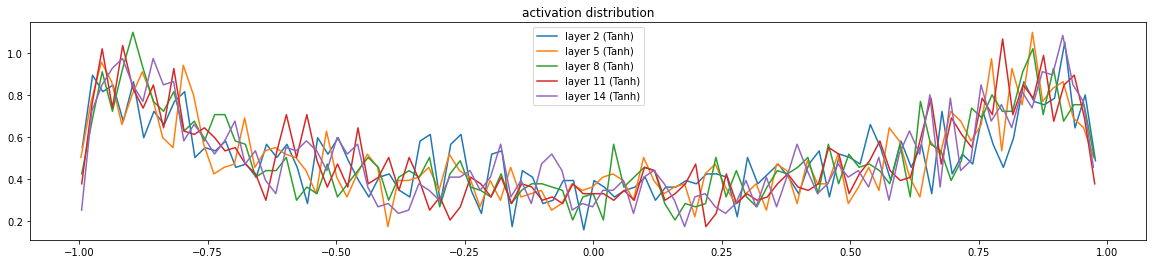

In [97]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height
legends = []

for i, layer in enumerate(layers[:-1]):
	if isinstance(layer, Tanh):
		t = layer.out
		print(f'layer %d (%s): mean %+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (torch.abs(t) > 0.97).float().mean()*100))
		hy, hx = torch.histogram(t, density=True)
		plt.plot(hx[:-1].detach(), hy.detach())
		legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('activation distribution');

layer 2 (Tanh): mean -0.000000, std 0.003644
layer 5 (Tanh): mean +0.000000, std 0.003247
layer 8 (Tanh): mean +0.000000, std 0.002962
layer 11 (Tanh): mean -0.000000, std 0.002737
layer 14 (Tanh): mean -0.000000, std 0.002577


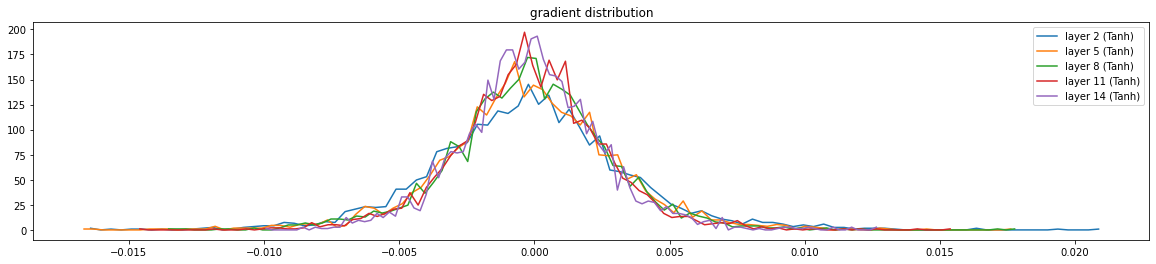

In [98]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height
legends = []

for i, layer in enumerate(layers[:-1]):
	if isinstance(layer, Tanh):
		t = layer.out.grad
		print(f'layer %d (%s): mean %+.6f, std %.6f' % (i, layer.__class__.__name__, t.mean(), t.std()))
		hy, hx = torch.histogram(t, density=True)
		plt.plot(hx[:-1].detach(), hy.detach())
		legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean -0.000000 | std 1.007700e-02 | grad to data ratio 1.006666e-02
weight  (30, 100) | mean +0.000082 | std 8.225077e-03 | grad to data ratio 2.631420e-02
weight (100, 100) | mean +0.000024 | std 7.317642e-03 | grad to data ratio 4.376285e-02
weight (100, 100) | mean -0.000019 | std 6.695946e-03 | grad to data ratio 3.969676e-02
weight (100, 100) | mean -0.000016 | std 5.858741e-03 | grad to data ratio 3.490114e-02
weight (100, 100) | mean +0.000054 | std 5.468968e-03 | grad to data ratio 3.257318e-02
weight  (100, 27) | mean -0.000148 | std 1.053031e-02 | grad to data ratio 6.317418e-02


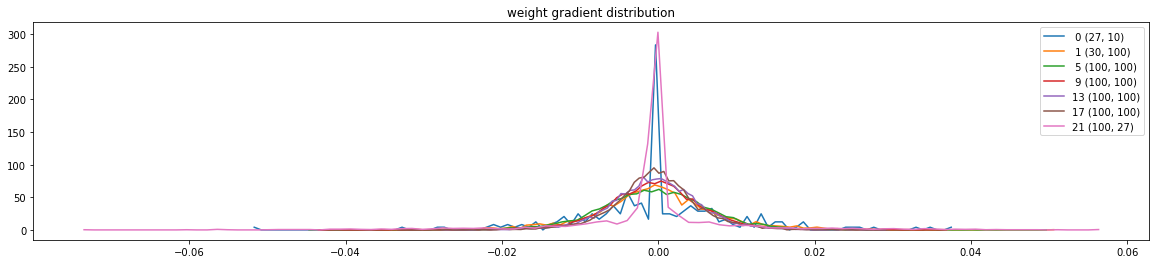

In [99]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height
legends = []

for i, p in enumerate(parameters):
	t = p.grad
	if p.ndim == 2:
		print('weight %10s | mean %+f | std %e | grad to data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
		hy, hx = torch.histogram(t, density=True)
		plt.plot(hx[:-1].detach(), hy.detach())
		legends.append(f'{i:2d} {tuple(p.shape)}')

plt.legend(legends);
plt.title('weight gradient distribution');

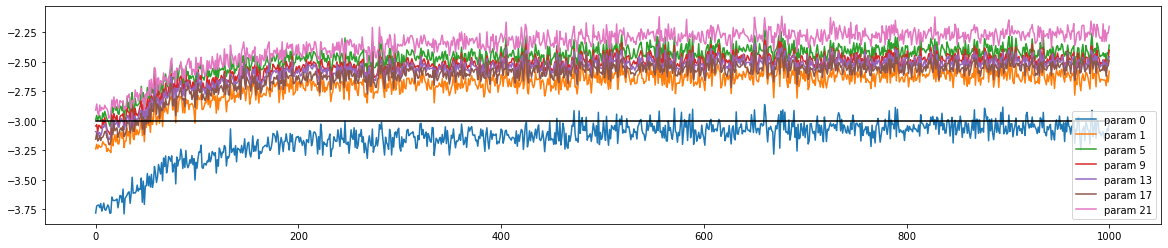

In [100]:
plt.figure(figsize=(20, 4)) # width and height
legends = []

for i, p in enumerate(parameters):
	if p.ndim == 2:
		plt.plot([update_to_data[j][i] for j in range(len(update_to_data))])
		legends.append('param %d' % i)

plt.plot([0, len(update_to_data)], [-3, -3], 'k')
plt.legend(legends);